In [28]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
df = pd.read_csv("data/output/df.csv")
processed_df = pd.read_csv("data/output/processed_df.csv")

In [47]:
# Function to get map recommendations based on a given level and job
def recommend_map_knn(level, job, level_range=5):
    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df.dropna(subset=['level', 'spec_filled', 'map'])
    
    # Filter the dataset to use only the data corresponding to the input job
    relevant_data = df_cleaned[(df_cleaned['level'] >= level - level_range) & 
                               (df_cleaned['level'] <= level + level_range) & 
                               (df_cleaned['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Prepare feature matrix (X) for KNN model: 'level', 'spec_filled'
    X = relevant_data[['level', 'spec_filled']].values
    maps_relevant = relevant_data['map'].values

    # KNN Model for finding similar maps based on features
    knn_relevant = NearestNeighbors(n_neighbors=3, algorithm='auto', metric='euclidean')
    knn_relevant.fit(X)

    # Create a feature vector for the input (level, spec_filled)
    input_spec_filled = relevant_data['spec_filled'].mean()  # Use the mean spec_filled value for input
    input_vector = np.array([[level, input_spec_filled]])

    # Find the top 3 nearest neighbors (maps) based on the input features
    distances, indices = knn_relevant.kneighbors(input_vector)
    
    # Get the top 3 map recommendations and their corresponding distances
    recommended_maps = maps_relevant[indices.flatten()]
    recommendation_scores = distances.flatten()

    # Remove duplicate maps if any
    recommended_maps = list(dict.fromkeys(recommended_maps))[:3]  # Limit to 3 unique maps

    # Sort the recommendations by raw distance (lower distance is better)
    sorted_recommendations = sorted(zip(recommended_maps, recommendation_scores), key=lambda x: x[1])

    # Visualize the KNN results
    if isinstance(recommended_maps, list):
        maps = relevant_data['map'].values
        levels = relevant_data['level'].values
        spec_filled = relevant_data['spec_filled'].values
        
        # Plot all data points
        plt.figure(figsize=(8, 6))
        plt.scatter(levels, spec_filled, c='gray', label='Data points', alpha=0.5)

        # Highlight the query point
        plt.scatter(level, input_spec_filled, c='red', label='Query point', s=100, marker='x')

        # Highlight the nearest neighbors
        nearest_neighbors = X[indices.flatten()]
        plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], c='blue', label='Nearest neighbors', s=100, marker='o')

        # Labels and title
        plt.xlabel('Level')
        plt.ylabel('Spec Filled')
        plt.title(f"KNN Visualization for Job: {job} and Level: {level}")
        plt.legend()

        # Show plot
        plt.show()
        # Output the recommended maps and their scores (raw distance)
        print("Recommended Maps and Scores:", recommended_maps)
    return sorted_recommendations

# Example usage
# recommended_maps = recommend_map(140, "썬콜", level_range=5)

In [48]:
# Function to get map recommendations based on a given level and job
def recommend_map_svd(level, job, level_range=5):

    # Filter out rows that do not belong to the specified job
    df_job_filtered = df[df['job'] == job]

    # Data Preprocessing: Remove rows with missing values in important columns
    df_cleaned = df_job_filtered.dropna(subset=['level', 'job', 'spec_filled', 'map'])
    
    # Calculate map usage frequency for each job
    map_usage_frequency = df_cleaned.groupby(['job', 'map']).size().reset_index(name='usage_count')
    
    # Calculate the total number of interactions for each job
    job_total_count = df_cleaned.groupby('job').size().reset_index(name='total_count')
    
    # Merge the usage count with the total count for each job
    map_usage_frequency = pd.merge(map_usage_frequency, job_total_count, on='job')
    
    # Calculate the percentage usage for each map within each job
    map_usage_frequency['usage_percentage'] = (map_usage_frequency['usage_count'] / map_usage_frequency['total_count']) * 100
    
    # Filter out maps used in less than 5% of the total interactions for each job
    valid_maps_per_job = map_usage_frequency[map_usage_frequency['usage_percentage'] >= 5]
    
    # Now filter the original dataframe to only keep rows with maps that meet the usage threshold
    df_cleaned_filtered = df_cleaned[df_cleaned['map'].isin(valid_maps_per_job['map'])]
    
    # Print the unique maps after preprocessing
    print("Unique maps after preprocessing:")
    print(df_cleaned_filtered['map'].unique())
    
    # Prepare the data for the recommendation system
    # Create a user-item interaction matrix where rows = users (party_id), columns = maps
    user_map_matrix = df_cleaned_filtered.pivot_table(index='party_id', columns='map', values='spec_filled', aggfunc='mean').fillna(0)
    
    # Apply Matrix Factorization using TruncatedSVD
    svd = TruncatedSVD(n_components=3, random_state=42)  # Using 3 latent factors for this example
    matrix_factorized = svd.fit_transform(user_map_matrix)
    
    # Get the cosine similarity between maps in the reduced space
    map_similarity = cosine_similarity(matrix_factorized.T)

    # Filter data based on the given level and job
    level_range_min = level - level_range
    level_range_max = level + level_range
    relevant_data = df_cleaned_filtered[(df_cleaned_filtered['level'] >= level_range_min) & 
                                       (df_cleaned_filtered['level'] <= level_range_max) & 
                                       (df_cleaned_filtered['job'] == job)]
    
    if relevant_data.empty:
        return "No data available for this job/level combination within the specified range."

    # Get the list of maps from the filtered data
    maps_relevant = relevant_data['map'].unique()

    # Ensure that the maps are present in the user_map_matrix
    valid_maps = [map_name for map_name in maps_relevant if map_name in user_map_matrix.columns]
    
    if not valid_maps:
        return "No valid maps available for recommendation."

    # Get the index of relevant maps in the reduced matrix (svd.transform)
    map_indices = [user_map_matrix.columns.get_loc(map_name) for map_name in valid_maps]
    
    # Ensure map_indices do not exceed the range of the reduced matrix (which has 3 factors)
    map_indices = [index for index in map_indices if index < len(map_similarity)]

    # Now calculate similarity scores for each relevant map with all other maps in the reduced matrix
    scores = np.mean(map_similarity[map_indices], axis=0)

    # Sort the scores and get top 3 recommended maps
    recommended_indices = np.argsort(scores)[::-1][:3]
    recommended_maps = user_map_matrix.columns[recommended_indices]
    
    # Print the similarity scores
    print("Similarity scores for recommended maps:")
    for map_name, score in zip(recommended_maps, scores[recommended_indices]):
        print(f"Map: {map_name}, Score: {score}")
    
    # Visualization of the SVD components and map recommendations
    # Visualize the maps in the SVD space (2D for simplicity)
    plt.figure(figsize=(10, 8))
    
    # Plot all maps in the reduced space (SVD components)
    plt.scatter(matrix_factorized[:, 0], matrix_factorized[:, 1], label="Maps", alpha=0.5, c='gray')
    
    # Highlight the recommended maps in a different color
    for idx in recommended_indices:
        plt.scatter(matrix_factorized[idx, 0], matrix_factorized[idx, 1], label=f"Recommended: {recommended_maps[idx]}", s=100, edgecolors='black')
    
    # Add labels for the recommended maps
    for idx in recommended_indices:
        plt.annotate(recommended_maps[idx], (matrix_factorized[idx, 0], matrix_factorized[idx, 1]), fontsize=12, ha='right', color='black')

    # Labeling and formatting the plot
    plt.title(f"SVD Map Visualization for Job: {job} and Level: {level}")
    plt.xlabel("SVD Component 1")
    plt.ylabel("SVD Component 2")
    plt.legend()
    plt.show()

    # Output the recommended maps
    print("Recommended Maps:", recommended_maps)
    # Return the top 3 recommended maps
    return recommended_maps.tolist()

# Example usage
# recommended_maps = recommend_map(140, "썬콜", level_range=5)

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE

def preprocess_data(df, numerical_features=["level", "spec_filled"]):
    """
    Preprocesses the data for t-SNE:
    - Encodes categorical features (e.g., job, map).
    - Fills missing values.
    - Normalizes numerical features.
    """
    # One-Hot Encode categorical features
    categorical_features = ["job", "map"]
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded_cats = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

    # Normalize numerical features (including spec_filled)
    df[numerical_features] = df[numerical_features].fillna(0)  # Fill NaNs
    scaler = StandardScaler()
    normalized_nums = scaler.fit_transform(df[numerical_features])
    normalized_df = pd.DataFrame(normalized_nums, columns=numerical_features)

    # Combine all features
    combined_df = pd.concat([normalized_df, encoded_df], axis=1)
    return combined_df

def filter_data_by_population(df, job_threshold=0.03, map_threshold=0.03, jobs=None):
    """
    Filters the dataset to include only jobs and maps with population >= threshold.
    Optionally filter by specified jobs.
    """
    # Calculate job and map population percentage
    job_counts = df['job'].value_counts(normalize=True)
    map_counts = df['map'].value_counts(normalize=True)
    
    # Filter jobs and maps by population percentage
    valid_jobs = job_counts[job_counts >= job_threshold].index
    valid_maps = map_counts[map_counts >= map_threshold].index
    
    if jobs is not None:
        valid_jobs = valid_jobs.intersection(jobs)  # Only keep specified jobs
    
    # Filter the dataset
    filtered_df = df[df['job'].isin(valid_jobs) & df['map'].isin(valid_maps)]
    return filtered_df

def tsne_visualization(df, perplexity=30, learning_rate=200, n_iter=1000, jobs=None):
    """
    Applies t-SNE to the dataset and visualizes the results, 
    only including job and map with > 3% population.
    Optionally, filter by specific jobs.
    """
    # Filter the data based on population threshold and specified jobs
    filtered_data = filter_data_by_population(df, jobs=jobs)
    
    # Preprocess the data
    processed_data = preprocess_data(filtered_data)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(processed_data)

    # Add t-SNE results to the original DataFrame
    filtered_data["tsne_dim1"] = tsne_results[:, 0]
    filtered_data["tsne_dim2"] = tsne_results[:, 1]

    # Get a color palette with enough colors
    num_maps = len(filtered_data['map'].unique())
    color_palette = sns.color_palette("tab20", n_colors=num_maps)  # "tab20" can be extended, or use another palette

    # Plot the t-SNE visualization
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=filtered_data, x="tsne_dim1", y="tsne_dim2", hue="map", style="job", 
        palette=color_palette, markers=["o", "s", "D", "^", "P", "X", "*", "H"], 
        s=100, alpha=0.7, edgecolor="w"
    )
    scatter.legend(loc="best", bbox_to_anchor=(1, 1), title="Job / Map")
    plt.title("t-SNE Visualization of job, map, level, spec_filled Features", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=14)
    plt.ylabel("t-SNE Dimension 2", fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

# tsne_visualization(df)
# tsne_visualization(df, jobs=["썬콜"])

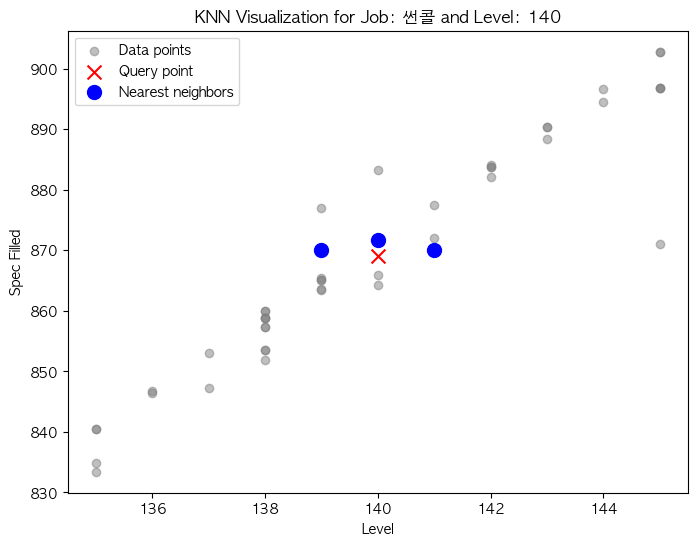

Recommended Maps and Scores: ['협동', '망용둥']
Unique maps after preprocessing:
['망용둥' '협동' '붉켄' '레와둥' '불어전']
Similarity scores for recommended maps:
Map: 망용둥, Score: 0.3333333333333334
Map: 불어전, Score: 0.3333333333333333
Map: 레와둥, Score: 0.3333333333333333


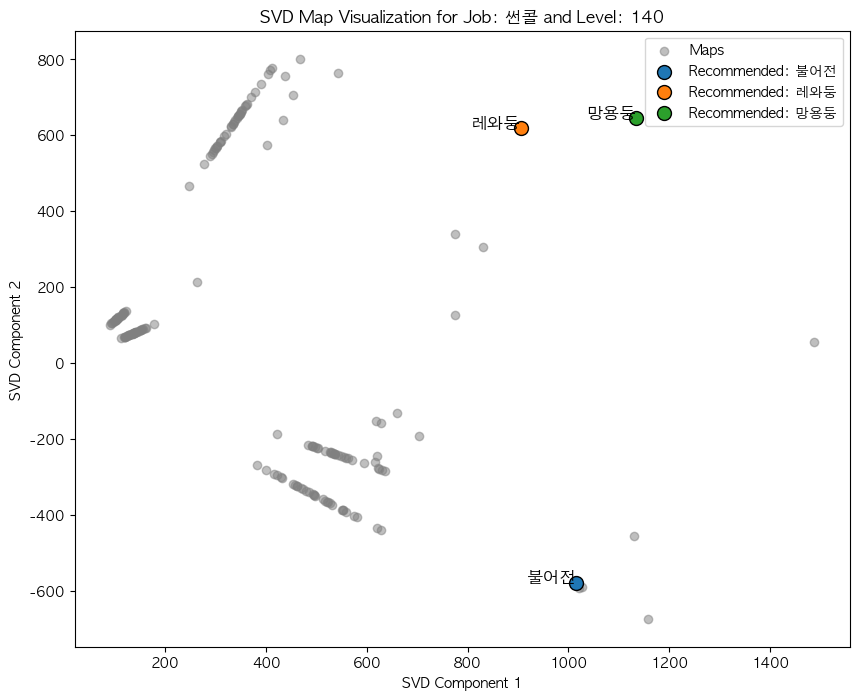

Recommended Maps: Index(['망용둥', '불어전', '레와둥'], dtype='object', name='map')


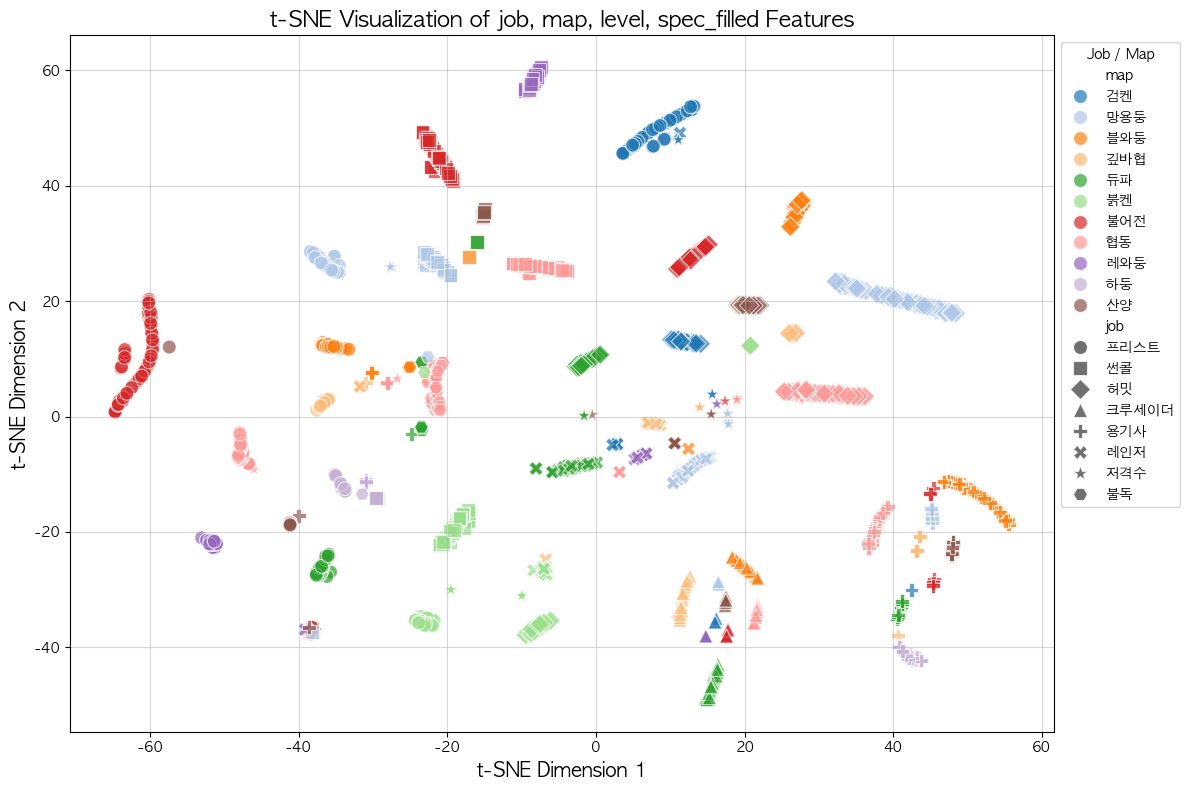

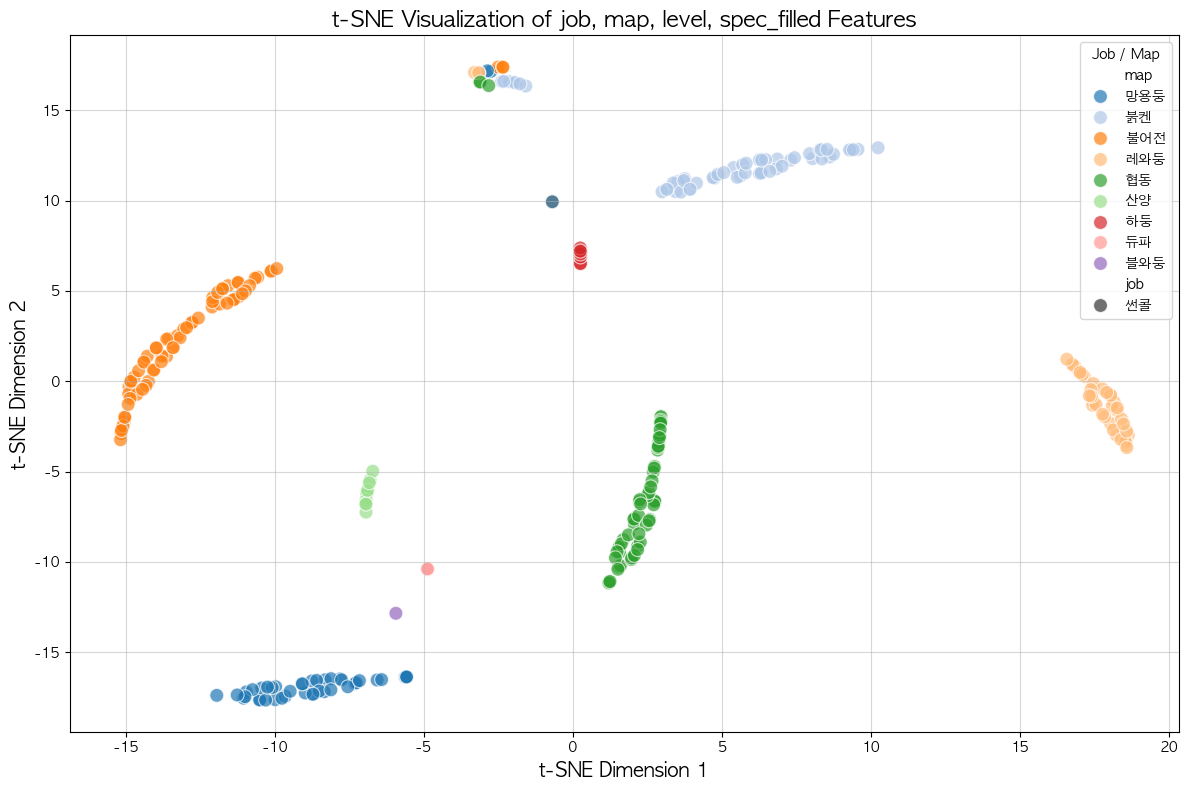

In [51]:
# recommend_map_knn(140, "썬콜", level_range=5)
# recommend_map_svd(140, "썬콜", level_range=5)
# tsne_visualization(df)
# tsne_visualization(df, jobs=["썬콜"])